# Project Notebook
##### Created by Dario Sandrucci 48436

bla bla bla

### 0. Import Packages

In [1]:
from data_engineering import *
from denoising_and_detoning import *
from algorithm import *
from portfolio_and_backtesting import *

### 1. Data Preparation and Exploration

##### 1.1 Loading Data

Let import return data from S&P 500 stocks over the period of approximately the last 10 years.

In [2]:
tickers = getTickers()
end = dt.now()
start = dt.fromisoformat('2012-10-15')
df = getData(start, end, tickers, downloaded = True)

Data was loaded sucessfully!


##### 1.2 Data Visualization

A chart the shows the percentage returns over the period of the sample.

In [ ]:
ax = df.plot(legend=False, figsize=(20,10))
ax.set_ylabel('percentage returns')
ax.set_title('Log Returns of S&P500 Stocks for Training Period')

A chart to show the cummulative returns of the SPY index over the data period.

In [ ]:
spy_returns = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
spy_returns = spy_returns.pct_change().dropna(axis = 0)
spy_cum = np.cumprod(1 + spy_returns) - 1
spy_cum.columns = ["S&P 500 Index"]

ax = spy_cum.plot(legend=False, figsize=(8,5))
ax.set_ylabel('cumulative returns')
ax.set_title('Cummulative returns of the S&P 500 Index over the period of the data set')

##### 1.3 Data Transformation

We will split the set into train and test set.

In [3]:
train_set, test_set = testTrainSplit(df, validation_set = False, w_tt = [0.9, 0.1])

Now lets derive the empirical correlation matrix of our return data.

In [4]:
corr0 = pd.DataFrame(getCorrMatrix(train_set), index = train_set.columns, columns = train_set.columns )

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr0)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr0, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

### 2. Denoise and Detone the Empirical correlation Matrix

Lets denoise the correlation matrix.

In [5]:
eVal0, eVec0, eVal1, eVec1, corr1, var0 = denoiseMatrix(corr0)

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr1)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr1, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

Next lets detone the correlation matrix.

In [6]:
corr2 = detoneMatrix(corr1, eVal1, eVec1)

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr2)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr2, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

## 3. Distance Metrics

We will use the mikowski distance metric. Our denoised and detoned correlation matrix is transformed accordingly.

In [7]:
from sklearn.metrics import pairwise_distances

In [8]:
min_matrix = np.array(pairwise_distances(corr2, metric = "minkowski"))

## 3. Portfolio Construction

#### 3.1 Clustering

##### 3.1.1 Finding the number of clusters

Our first method is the Elbow method

In [ ]:
nr_clusters_sse = sse(min_matrix)

Now lets try the Silhouette method

In [ ]:
nr_clusters_sil = sil_score(min_matrix)

Our last method is the Davies-Boulding Score

In [ ]:
nr_clusters_db = db_score(min_matrix)

We will use the median number of clusters for for Kmeans.

##### 3.1.2 Running the clustering algorithm

In [ ]:
w = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5)

## 4. Perfromance evaluation

#### 4.1. Benchmarking

##### 4.1.1 Clustering vs general portfolios

We will compare our clustering portfolio with a few other common portfolio types, the mean-variance optimized (MVP), risk-parity (RPP), and equal-weighted portfolio (EWP), as well as the S&P index itself (SPY).

First let calculated the portfolio weights:

In [9]:
#Clustering
w_NCOMO = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5)
#EW
w_EW = np.ones(len(train_set.columns))
w_EW /= [len(train_set.columns)]*len(train_set.columns)
#MVO
w_MVO = optPortMVO(train_set)
#RPP
w_RPP = optPortRPP(train_set)


Nested Clustering Algorithm 2.1.2

Processing input data....
Clustering algorithm in progress...


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Calculating inter cluster weights for cluster 1 of 3...


100%|██████████| 50/50 [00:01<00:00, 49.11it/s]


Calculating inter cluster weights for cluster 2 of 3...


100%|██████████| 50/50 [00:00<00:00, 53.21it/s]


Calculating inter cluster weights for cluster 3 of 3...


100%|██████████| 50/50 [00:00<00:00, 54.36it/s]


Calculating inter cluster weights...


100%|██████████| 50/50 [00:00<00:00, 54.78it/s]


Nested clustering algorithm completed sucessful!


100%|██████████| 100000/100000 [00:27<00:00, 3679.71it/s]


Not lets build the portfolios:

In [ ]:
#building the single portfolios
port_NCOMO = Portfolio("NCO Minkowski Omega", test_set, w_NCOMO)
port_EWP = Portfolio("Equal Weighted", test_set, w_EW)
port_MVO = Portfolio("Mean Variance", test_set, w_MVO)
port_RPP = Portfolio("Risk Parity", test_set, w_RPP)
#comparing the portfolios
BM1 = PortfolioBenchmarking([port_NCOMO, port_EWP, port_MVO, port_RPP])

We are ready to perform some comparisons:

In [ ]:
BM1.plot_performance()

##### 4.1.2 Cluster algorithm configurations

We will now compare different configurations of the NCO to see the impact of different inputs. First lets calculate again the different weights:

In [10]:
# Investing just in a portfolio mean-variance optimized with the denoised and detoned correlation matrix
cov0 = corr2cov(corr2)
w_cov_only = optPortMVO(train_set, cov = cov0, cov_in = True)

# NCO with normal correlation matrix and omega opimization
dist_matrix = pairwise_distances(corr2)
w_NCO_DO = optPort_nco(train_set, dist_matrix, 3, 0.5, 50, 5)

# NCO with minkowski distance matrix and sharpe opimization
dist_matrix = pairwise_distances(corr2)
w_NCO_MS = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5)

# NCO with normal correlation matrix and sharpe opimization
dist_matrix = pairwise_distances(corr2)
w_NCO_DS = optPort_nco(train_set, dist_matrix, 3, 0.5, 50, 5)

100%|██████████| 100000/100000 [00:32<00:00, 3089.34it/s]



Nested Clustering Algorithm 2.1.2

Processing input data....
Clustering algorithm in progress...


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Calculating inter cluster weights for cluster 1 of 3...


100%|██████████| 50/50 [00:01<00:00, 29.65it/s]


Calculating inter cluster weights for cluster 2 of 3...


100%|██████████| 50/50 [00:01<00:00, 36.96it/s]


Calculating inter cluster weights for cluster 3 of 3...


100%|██████████| 50/50 [00:01<00:00, 38.22it/s]


Calculating inter cluster weights...


100%|██████████| 50/50 [00:00<00:00, 50.24it/s]


Nested clustering algorithm completed sucessful!

Nested Clustering Algorithm 2.1.2

Processing input data....
Clustering algorithm in progress...


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Calculating inter cluster weights for cluster 1 of 3...


100%|██████████| 50/50 [00:00<00:00, 60.04it/s]


Calculating inter cluster weights for cluster 2 of 3...


100%|██████████| 50/50 [00:00<00:00, 56.93it/s]


Calculating inter cluster weights for cluster 3 of 3...


100%|██████████| 50/50 [00:00<00:00, 53.73it/s]


Calculating inter cluster weights...


100%|██████████| 50/50 [00:01<00:00, 42.18it/s]


Nested clustering algorithm completed sucessful!

Nested Clustering Algorithm 2.1.2

Processing input data....
Clustering algorithm in progress...


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Calculating inter cluster weights for cluster 1 of 3...


100%|██████████| 50/50 [00:01<00:00, 46.14it/s]


Calculating inter cluster weights for cluster 2 of 3...


100%|██████████| 50/50 [00:00<00:00, 54.94it/s]


Calculating inter cluster weights for cluster 3 of 3...


100%|██████████| 50/50 [00:00<00:00, 57.15it/s]


Calculating inter cluster weights...


100%|██████████| 50/50 [00:01<00:00, 35.15it/s]

Nested clustering algorithm completed sucessful!


Let's build the portfolios

In [13]:
# Correlation matrix only
port_COV = Portfolio("Denoised and Detoned", test_set, w_cov_only)
# Minkowski Omega
port_NCOMO = Portfolio("NCO Minkowski Omega", test_set, w_NCOMO)
# Minkowski Sharpe
port_NCOMS = Portfolio("NCO Minkowski Sharpe", test_set, w_NCO_MS)
# Correlation Omega
port_NCODO = Portfolio("NCO Correlation Omega", test_set, w_NCO_DO)
# Correlation Sharpe
port_NCODS = Portfolio("NCO Correlation Sharpe", test_set, w_NCO_DS)

# Combined
BM2 = PortfolioBenchmarking([port_COV, port_NCOMO, port_NCOMS, port_NCODO, port_NCODS])

Performance Comparison

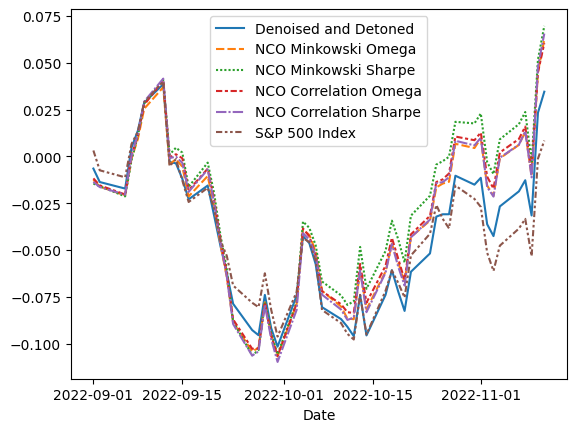

In [15]:
BM2.plot_performance()

##### 4.1.3 Long-Only vs. Long-Short

Lets get the portfolio weights

In [16]:
# Long Only
w_NCOMO_LO = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5, constraint = "Long-Only")
#Long Short
w_NCOMO_LO = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5, constraint = "Long-Short")

TypeError: optPort_nco() got an unexpected keyword argument 'constraint'